# Analyze
---

## multi-fx

In [1]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np

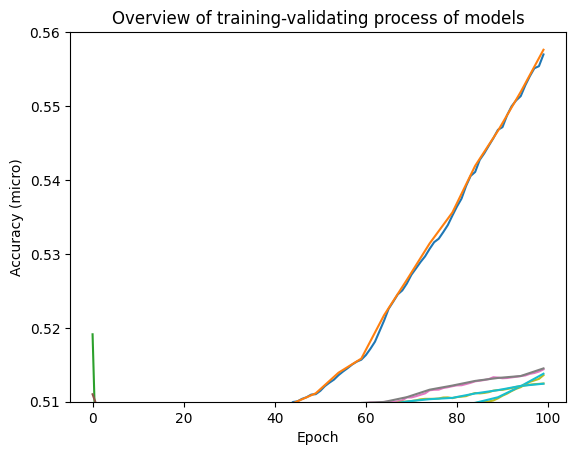

In [2]:
log = {}
for filename in os.listdir('./pretrained_micro'):
    if filename.endswith('.json'):
        with open(f'./pretrained_micro/{filename}', 'r') as fi:
            log[filename] = json.load(fi)

# this is for micro_metric, but it's wrong since it only print out the metric of the final batch of each task
# even that, these logs're still useful in analyze the model architecture and hyper-parameters 
# when it performs on test set, the accuracy is about 70%
x_axis = np.arange(-1,100,5)
x_axis[0] = 0

plt.xlabel('Epoch')
plt.ylabel('Accuracy (micro)')
plt.title('Overview of training-validating process of models')
for model in log.keys():
    plt.plot(range(100), log[model]['train_acc'])
    plt.plot(x_axis, log[model]['val_acc'])
    # plt.title(f'{model}_acc')
    # plt.show()
    plt.ylim((0.51,0.56))
    # break

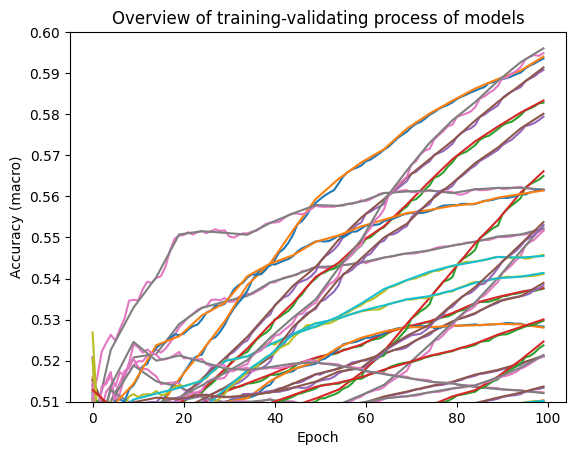

In [3]:
log = {}
for filename in os.listdir('./pretrained_macro'):
    if filename.endswith('.json'):
        with open(f'./pretrained_macro/{filename}', 'r') as fi:
            log[filename] = json.load(fi)

x_axis = np.arange(-1,100,5)
x_axis[0] = 0

plt.xlabel('Epoch')
plt.ylabel('Accuracy (macro)')
plt.title('Overview of training-validating process of models')
plt.ylim((0.51,0.6))
for model in log.keys():
    plt.plot(range(100), log[model]['train_acc'])
    plt.plot(x_axis, log[model]['val_acc'])

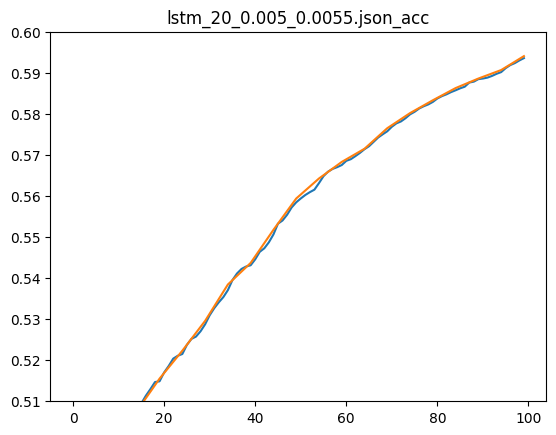

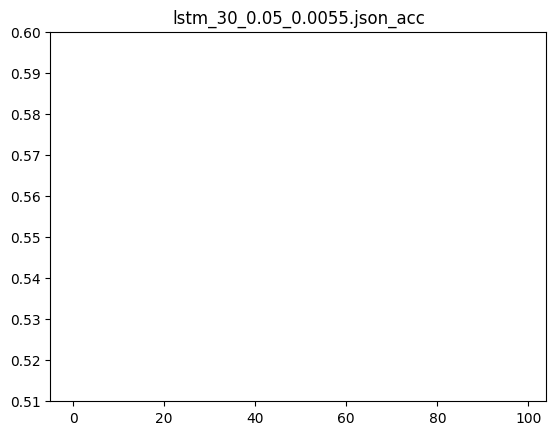

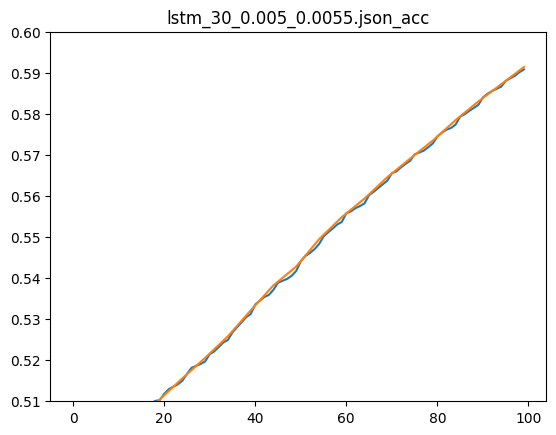

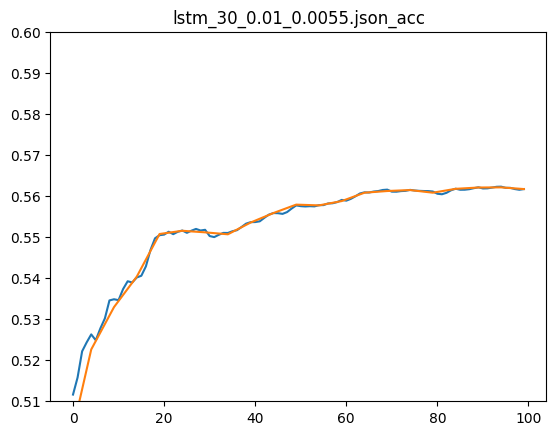

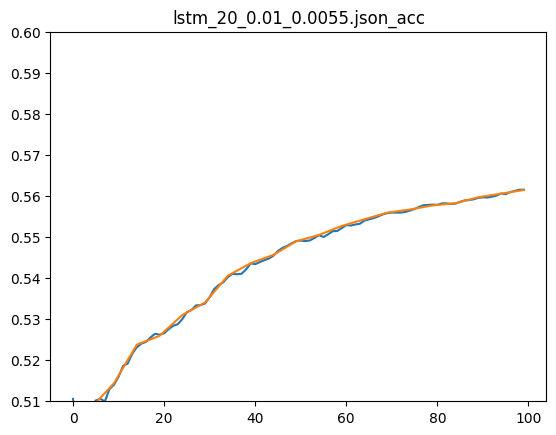

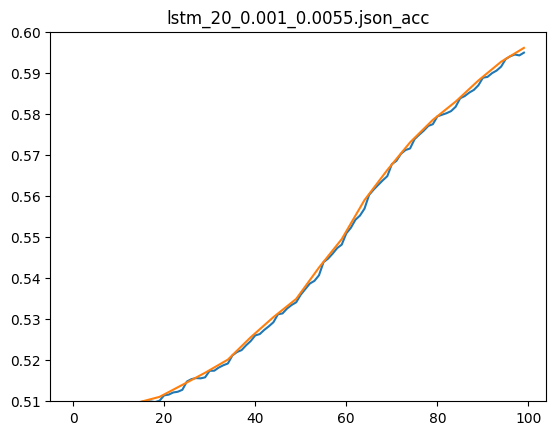

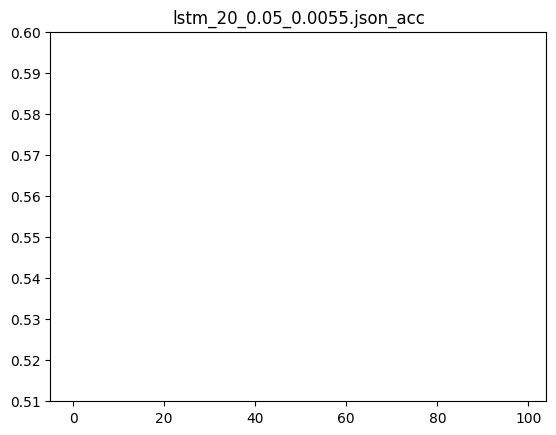

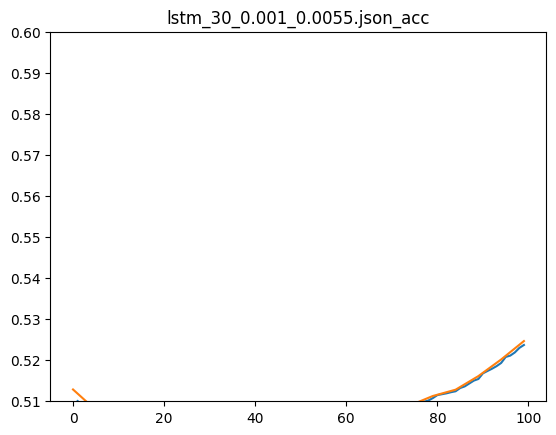

In [4]:
log = {}
for filename in os.listdir('./pretrained_macro'):
    if filename.endswith('0.0055.json') and (filename.startswith('lstm_20') or filename.startswith('lstm_30')):
        with open(f'./pretrained_macro/{filename}', 'r') as fi:
            log[filename] = json.load(fi)

x_axis = np.arange(-1,100,5)
x_axis[0] = 0
for model in log.keys():
    plt.plot(range(100), log[model]['train_acc'])
    plt.plot(x_axis, log[model]['val_acc'])
    plt.title(f'{model}_acc')
    plt.ylim((0.51,0.6))
    plt.show()
    # break

## multi-USD/JPY

- This task should be analyze based on the output of 3 methods:
    - Split data into 60 tasks, then meta-train
    - Adapt the pre-trained multi-fx on 20% of data, then test on 80% of data
    - Use federated learning and check if it would help (maybe no need)

### Split data, then meta-train

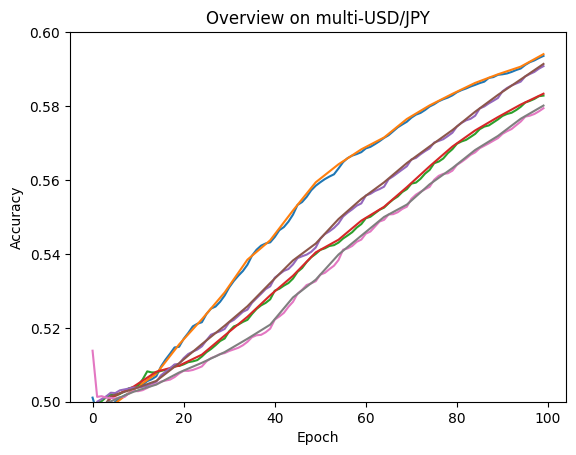

In [5]:
# function `submit_tunned_model` in submit_jobs.py, submit our 3 best models
import matplotlib.pyplot as plt
import json
import os
import numpy as np

log = {}
for filename in os.listdir('./pretrained_macro_jp'):
    if filename.endswith('.json'):
        with open(f'./pretrained_macro/{filename}', 'r') as fi:
            log[filename] = json.load(fi)

x_axis = np.arange(-1,100,5)
x_axis[0] = 0
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Overview on multi-USD/JPY')
for model in log.keys():
    plt.plot(range(100), log[model]['train_acc'])
    plt.plot(x_axis, log[model]['val_acc'])
    # plt.title(f'{model}_acc')
    plt.ylim((0.5,0.6))
    # plt.show()
    # break

### Adapt pre-trained multi-fx model

- I've tried the following code in `fx` repo
- The results are quite bad even when I increased the epoch
- I think that the model should be more complicated to fit such a big data like that (in meta-learning, we only fit a small amount of data, so the model doesn't have to be complicated)

In [ ]:
# this code should be run in `pre_process.py` in `fx` repo

import tensorflow as tf
from keras import optimizers, models, metrics
from common.common import get_data
import json

info = get_data("u", "h", 30)
X_train = np.array(info['X_train'])
X_val = np.array(info['X_val'])
y_train = np.where(np.array(info["y_train"]) > 0, 1, 0)
y_val = np.where(np.array(info["y_val"]) > 0, 1, 0)

tf.config.threading.set_inter_op_parallelism_threads(26)
tf.config.threading.set_intra_op_parallelism_threads(26)

pre_trained:models.Model = tf.keras.models.load_model('/home/s2210434/multi_fx/pretrained_macro/lstm_30_0.005_0.0055.keras')
pre_trained.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss=metrics.binary_crossentropy, metrics=['accuracy'])
history = pre_trained.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_val, y_val))
with open('./tmp.json', 'w') as fo:
    json.dump(str(history), fo)

## Prove that AutoKeras's suck

In [6]:
import matplotlib.pyplot as plt
import os

def draw_process(log_path:str):
    # read all lines
    with open(log_path, 'r') as fi:
        data = fi.readlines()

    # extract best accuracy
    best_acc = float(data[-2].split(': ')[-1])

    # detect training process which achieves the best acc
    trigger_str = 'Best val_accuracy'
    prev_trigger = -1
    cur_trigger = -1
    for idx, line in enumerate(data):
        if str(best_acc) in line and trigger_str in line:
            cur_trigger = idx
            print(prev_trigger, idx)
            break
        if trigger_str in line:
            prev_trigger = idx

    # extract this training process
    accuracies = []
    losses = []
    for idx, line in enumerate(data[prev_trigger: cur_trigger]):
        if 'val_loss' in line:
            splitted_components = line.split('-')
            acc = float(splitted_components[-2].split(':')[-1])
            loss = float(splitted_components[-1].split(':')[-1])
            accuracies.append(acc)
            losses.append(loss)

    # draw
    plt.plot(accuracies)
    plt.title(f'best_acc: {best_acc:.5f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    # plt.ylim(0.45, 0.6)


1164345 1178572


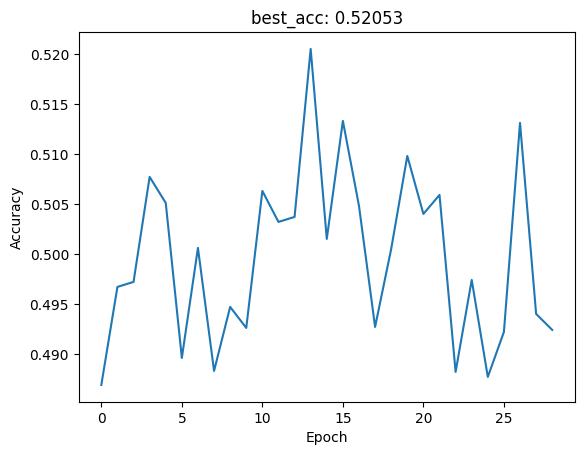

77763 79773


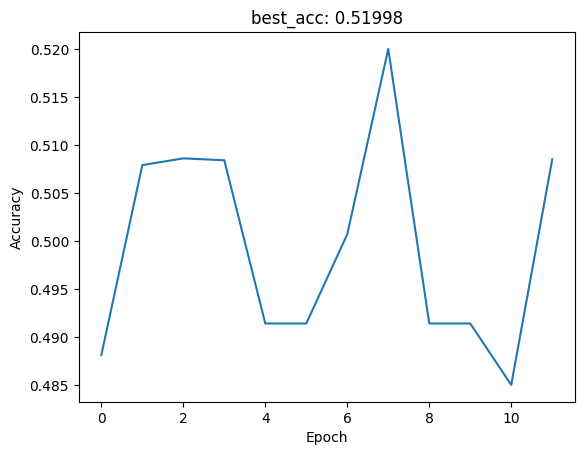

ccdd_u_h_20.log
211995 214663


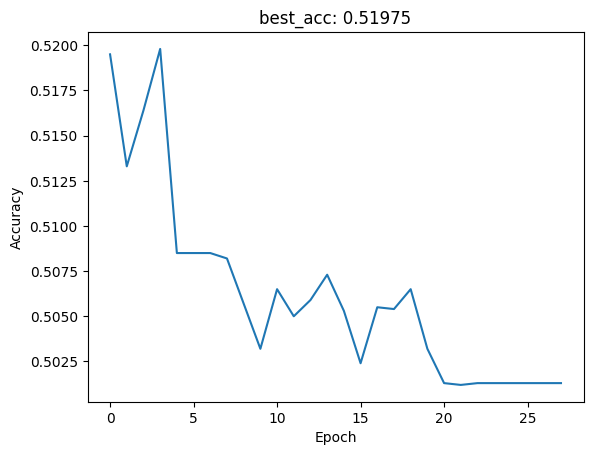

810557 816228


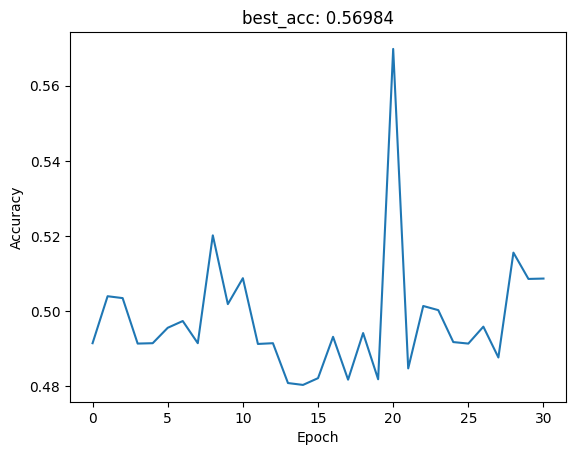

867205 875422


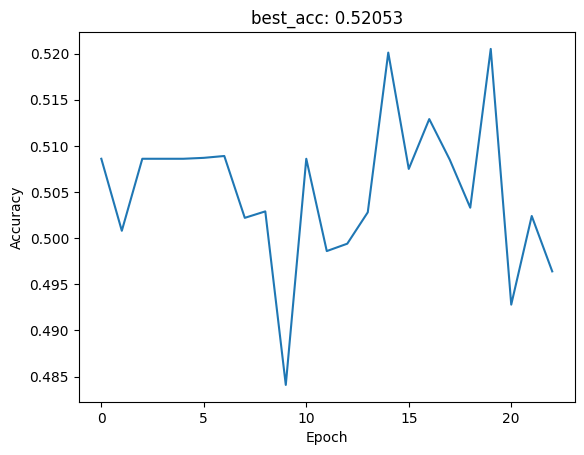

242740 244800


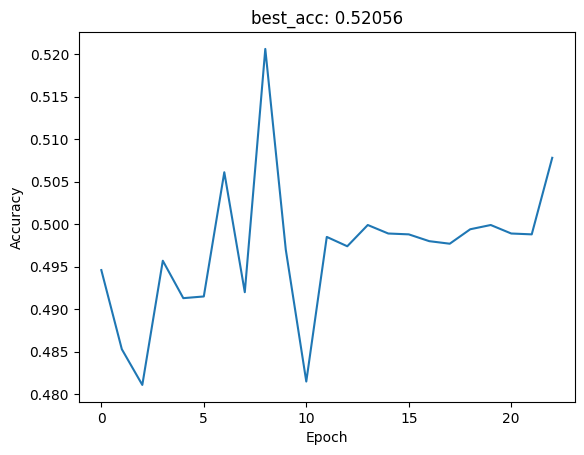

125652 126770


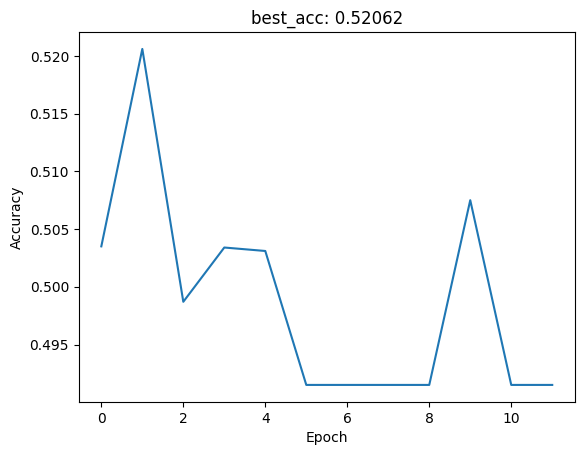

152881 154287


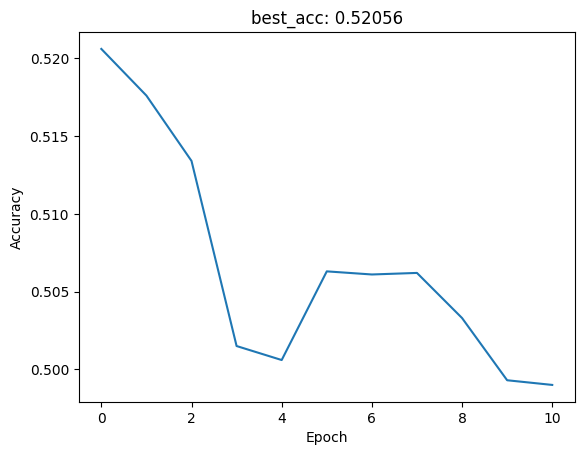

In [8]:
log_dir = '/home/s2210434/fx/execute/log/multi_fx_log'

for filename in os.listdir(log_dir):
    try:
        draw_process(f'{log_dir}/{filename}')
    except:
        print(filename)